In [104]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import expon, norm, entropy, probplot
from scipy.optimize import minimize
from itertools import product

# params
np.random.seed(42)
levels = 50
bias = 0.5  # for hadamard walk
expon_bias = 0.8
target = "normal"  # can change to "exponential"

#set up standard binomal distribution to compare
probs = np.random.normal(loc=levels/2, scale=np.sqrt(levels)/2, size=100000)
probs, _ = np.histogram(probs, bins=levels+1, range=(0, levels+1), density=True)

#normal distribution references
x_vals = np.linspace(0, levels, len(probs))
target_pdf = norm.pdf(np.linspace(-3, 3, len(probs)))
target_pdf /= np.sum(target_pdf)

#exponential distribution targets
x_vals_2 = np.linspace(0, 5, levels + 1)
exp_pdf = expon.pdf(x_vals)
exp_pdf /= np.sum(exp_pdf)

In [105]:
# first, we build the QGB as a classical network (not neural net)
def build_galton_graph(levels, bias):
    """A classical probabilistic representation of trajectory of a quantum ball.
    Nodes: positions of ball at a specific level
    Edges: Probabilities of transitioning left/right through the following gates"""
    G = nx.DiGraph()
    node_id = lambda level, pos: f"{level}-{pos}"
    for level in range(levels):
        for pos in range(level + 1):
            curr = node_id(level, pos)
            left = node_id(level + 1, pos)
            right = node_id(level + 1, pos + 1)
            G.add_edge(curr, left, weight=1 - bias)
            G.add_edge(curr, right, weight=bias)
    return G
#we'll do a direct graph

In [106]:
#  Simulate Random Walk
def simulate_distribution(G, levels):
    start = "0-0"
    dist = {node: 0.0 for node in G.nodes()}
    dist[start] = 1.0
    for level in range(levels):
        next_dist = {node: 0.0 for node in G.nodes()}
        for node in dist:
            for succ in G.successors(node):
                next_dist[succ] += dist[node] * G[node][succ]['weight']
        dist = next_dist
    final_nodes = [n for n in dist if n.startswith(f"{levels}-")]
    probs = np.array([dist[n] for n in final_nodes])
    return probs / np.sum(probs)


In [107]:
# QAOA Optimization processing
def qaoa_postprocess(probs, gamma, beta):
    angles = np.linspace(-np.pi, np.pi, len(probs))
    phased = probs * np.cos(gamma * angles) ** 2
    mixed = np.fft.ifft(np.fft.fft(phased) * np.exp(-1j * beta)).real
    return np.clip(mixed, 0, None) / np.sum(np.clip(mixed, 0, None))

In [108]:
def get_target_distribution(length, target="normal"):
    """"Getting normal/exponential/hadamard walk"""
    if target == "normal":
        x = np.linspace(-3, 3, length)
        ref = norm.pdf(x)
    elif target == "exponential":
        x = np.linspace(0, 5, length)
        ref = np.exp(-x)
    else:
        raise ValueError("Unsupported target")
    return ref / np.sum(ref)

In [109]:

def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def kl_divergence(p, q):
    # NOTE: add small epsilon to avoid division by zero
    p = np.clip(p, 1e-12, 1)
    q = np.clip(q, 1e-12, 1)
    return entropy(p, q)
#there are a lotta of statistical distances so we can test em out
# maybe like euclidean or manhattan

In [110]:
# Objective Function
def objective(params, probs, target_ref):
    gamma, beta = params
    processed = qaoa_postprocess(probs, gamma, beta)
    return kl_divergence(processed, target_ref)

In [113]:
#Run and optimize as much as possible
G = build_galton_graph(levels, bias)
probs = simulate_distribution(G, levels)
target_ref = get_target_distribution(len(probs), target=target)

res = minimize(objective, x0=[10.0, 10.0], bounds=[(0, 2*np.pi), (0, 2*np.pi)])
best_gamma, best_beta = res.x
probs_qaoa = qaoa_postprocess(probs, best_gamma, best_beta)

# --- KL divergence values ---
kl_orig = kl_divergence(probs, exp_pdf)
kl_qaoa = kl_divergence(probs_qaoa, exp_pdf)

TypeError: objective() missing 2 required positional arguments: 'probs' and 'target_ref'

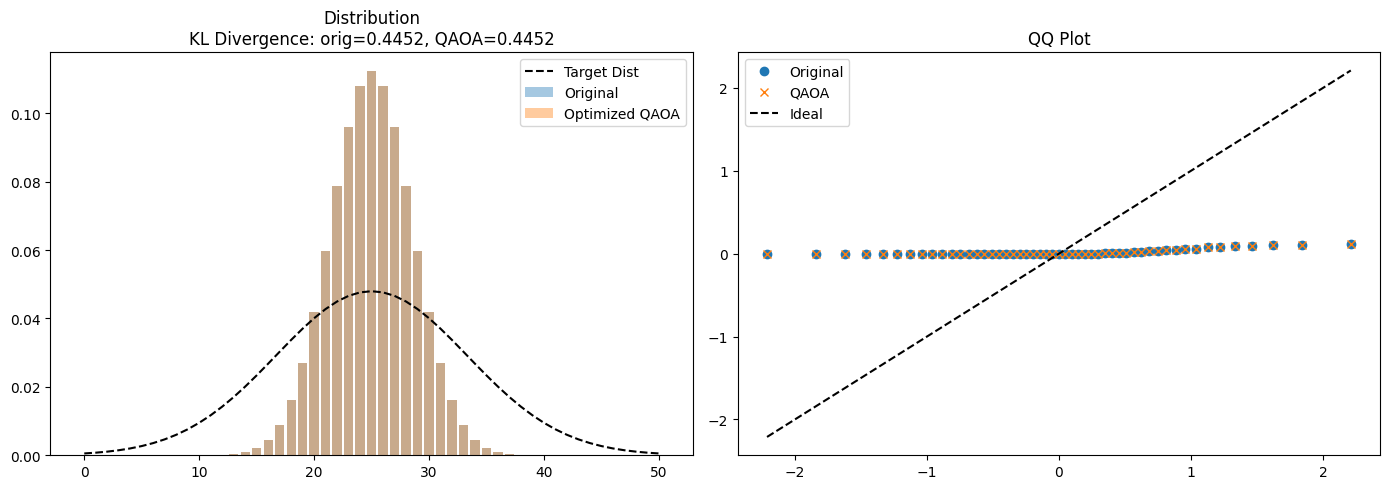

(np.float64(0.0),
 np.float64(0.5000008109300669),
 np.float64(0.44523171241698767),
 np.float64(0.44523171241698695))

In [ ]:
# Plot it

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(x_vals, probs_orig, alpha=0.4, label="Original")
axs[0].bar(x_vals, probs_qaoa, alpha=0.4, label="Optimized QAOA")
axs[0].plot(x_vals, exp_pdf, 'k--', label="Exponential Dist")
axs[0].set_title(f"Distribution\nKL Divergence: orig={kl_orig:.4f}, QAOA={kl_qaoa:.4f}")
axs[0].legend()

# QQ Plot
sorted_exp = np.sort(np.random.choice(x_vals, p=exp_pdf, size=1000))
sorted_orig = np.sort(np.random.choice(x_vals, p=probs_orig, size=1000))
sorted_qaoa = np.sort(np.random.choice(x_vals, p=probs_qaoa, size=1000))

axs[1].plot(sorted_exp, sorted_orig, 'o', label="Original", alpha=0.6)
axs[1].plot(sorted_exp, sorted_qaoa, 'x', label="QAOA", alpha=0.6)
axs[1].plot(sorted_exp, sorted_exp, 'k--', label="Ideal")
axs[1].set_title("QQ Plot: Exponential vs Circuit Outputs")
axs[1].legend()

plt.tight_layout()
plt.show()

In [97]:
#okay not very normal distribution that sucks, we need to find the best gamma beta values
gamma_range = np.linspace(0, 2*np.pi, 30)
beta_range = np.linspace(0, 2*np.pi, 30)
best_params = None
min_kl = float("inf")

In [99]:
for gamma, beta in product(gamma_range, beta_range):
    processed = qaoa_postprocess(probs, gamma, beta)
    kl = kl_divergence(processed, target_pdf)
    if kl < min_kl:
        min_kl = kl
        best_params = (gamma, beta)

 
best_gamma, best_beta = best_params
probs_qaoa = qaoa_postprocess(probs, best_gamma, best_beta)
kl_original = kl_divergence(probs, target_pdf)
kl_qaoa = kl_divergence(probs_qaoa, target_pdf)



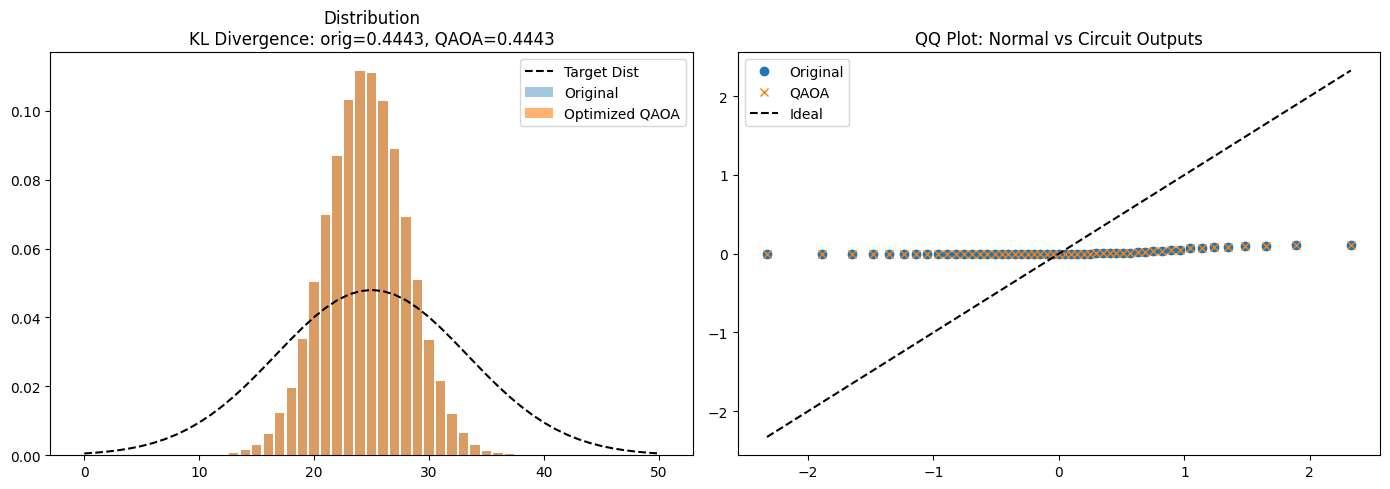

(np.float64(0.0),
 np.float64(1.5166309362157622),
 np.float64(0.44428573577365105),
 np.float64(0.44428573577365005))

In [ ]:
#Plot to find best beta & gamma

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Bar graph
axs[0].bar(x_vals, probs, alpha=0.4, label="Original")
axs[0].bar(x_vals, probs_qaoa, alpha=0.6, label="Optimized QAOA")
axs[0].plot(x_vals, target_pdf, 'k--', label="Target Dist")
axs[0].set_title(f"Distribution\nKL Divergence: orig={kl_original:.4f}, QAOA={kl_qaoa:.4f}")
axs[0].legend()

# QQ Plot
qq_x = norm.ppf(np.linspace(0.01, 0.99, len(probs)))
qq_y_orig = np.sort(probs)
qq_y_qaoa = np.sort(probs_qaoa)
axs[1].plot(qq_x, qq_y_orig, 'o', label="Original")
axs[1].plot(qq_x, qq_y_qaoa, 'x', label="QAOA")
axs[1].plot(qq_x, qq_x, 'k--', label="Ideal")
axs[1].set_title("QQ Plot: Normal vs Circuit Outputs")
axs[1].legend()

plt.tight_layout()
plt.show()

(best_gamma, best_beta, kl_original, kl_qaoa)

#these gamma and beta values will not bring a proper normal distribution...